**Task1: Acquire the Dataset**

In [ ]:
#Import Dataset
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [ ]:
#Vectorize
import numpy as np
x_train=np.reshape(x_train,(60000,784))
x_test=np.reshape(x_test,(10000,784))

In [ ]:
x_train_unnorm = x_train
x_test_unnorm = x_test

In [ ]:
#Normalize Data
x_train =x_train/np.std(x_train, axis = 0)
x_test=x_test/np.std(x_test,axis=0)

In [ ]:
n_features = x_train.shape[-1]

**Task2: Implement MLP to classify image**

In [ ]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

from typing import List
from tqdm import tqdm

In [ ]:
#Construct NeutralNetLayer
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

In [ ]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size, l2reg: float):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.normal(0,0.2,(output_size, input_size))
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]
        self.l2 = l2reg

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        #dw = gradient[:, :, None] @ self.cur_input[:, None, :] + 0.0001/self.no*self.w
        dw = gradient[:, :, None] @ self.cur_input[:, None, :] + self.l2*self.w
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

In [ ]:
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        exps = np.exp(x)
        probs = (exps+0.001) / (np.sum((exps+0.001), axis=-1))[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

In [ ]:
import random
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)
    def fit(self, lr: float, data_x, data_y, steps,batch_size):
        opt = GradientDescentOptimizer(self, lr)
        losses = []
        for _ in tqdm(range(steps)):
            indices = np.arange(data_x.shape[0])
            np.random.shuffle(indices)
            for ind in range(0, data_x.shape[0] - batch_size + 1, batch_size):
                mb_ind = indices[ind:ind + batch_size]
                minix = data_x[mb_ind]
                miniy = data_y[mb_ind]
                labels = np.eye(10)[np.array(miniy)]
                predictions = self.forward(minix)
                loss = -(labels * np.log(predictions)).sum(axis=-1).mean()
                losses.append(loss)
                self.backward(labels)
                opt.step()
            
        plt.plot(losses)
        plt.xlabel("Epoch")
        plt.ylabel("Cross entropy loss")
    def predict(self, xtest):
        prob = self.forward(xtest)
        pred = prob.argmax(axis=1)
        return pred

In [ ]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
          # g+=2*0.1*p[0]
          # p -= self.lr * g.mean(axis=0) 
          p -= self.lr * g.mean(axis=0)

In [ ]:
#Accuracy Function
#Accuracy = correctly classified / total classified
def accuracy_score(y_true,y_pred):

  accuracy_score=sum(y_true==y_pred)/len(y_true)
  return accuracy_score

**Task 3** 

**3.1 Three models with no hidden layer, 1 hidden layer, and 2 hidden layers**

In [ ]:
HIDDEN_SIZE = 128
GRADIENT_STEPS = 10
BATCH_SIZE = 2000

100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


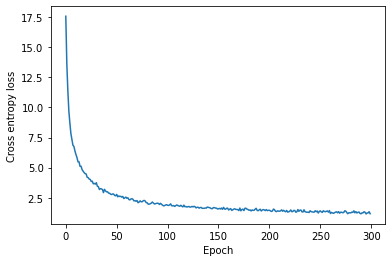

In [ ]:
mlp1 = MLP(
    LinearLayer(n_features, 10, 0),
    SoftmaxOutputLayer()
)

mlp1.fit(1e-2, x_train, y_train, GRADIENT_STEPS,BATCH_SIZE)

In [ ]:
p1 = mlp1.predict(x_test)
acc = accuracy_score(y_test,p1)
acc

0.6595

100%|██████████| 10/10 [08:31<00:00, 51.16s/it]


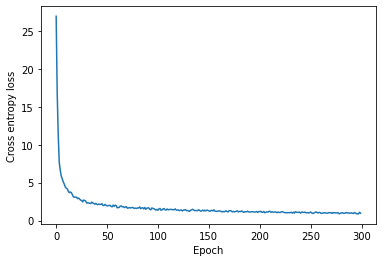

In [ ]:
mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE, 0),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10, 0),
    SoftmaxOutputLayer()
)

mlp2.fit(1e-2, x_train, y_train, GRADIENT_STEPS,BATCH_SIZE)

In [ ]:
p2 = mlp2.predict(x_test)
acc2 = accuracy_score(y_test,p2)
acc2

0.7286

In [ ]:

mlp3 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE, 0),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE, 0),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10, 0),
    SoftmaxOutputLayer()
)

mlp3.fit(1e-2, x_train, y_train, GRADIENT_STEPS,BATCH_SIZE)


 70%|███████   | 7/10 [06:14<02:42, 54.33s/it]

In [ ]:
p3 = mlp3.predict(x_test)
acc3 = accuracy_score(y_test,p3)
acc3

0.7713

**3.2 Model using tanh and Leaky-ReLU function**

In [ ]:
class TanhLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        tan = np.tanh(x)
        tansquare = tan * tan
        self.gradient = 1 - tansquare
        return tan

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        alpha = 0.01
        self.gradient = np.where(x > 0, 1.0, alpha)
        return np.maximum(0, x) + alpha * np.minimum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
mlp_tanh = MLP(
    LinearLayer(n_features, HIDDEN_SIZE, 0),
    TanhLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE, 0),
    TanhLayer(),
    LinearLayer(HIDDEN_SIZE, 10, 0),
    SoftmaxOutputLayer()
)

mlp_tanh.fit(1e-2, x_train, y_train, GRADIENT_STEPS,BATCH_SIZE)

p_tanh = mlp_tanh.predict(x_test)
acc_tanh = accuracy_score(y_test,p_tanh)
acc_tanh

In [ ]:
mlp_leaky = MLP(
    LinearLayer(n_features, HIDDEN_SIZE, 0),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE, 0),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10, 0),
    SoftmaxOutputLayer()
)

mlp_leaky.fit(1e-2, x_train, y_train, GRADIENT_STEPS,BATCH_SIZE)

p_leaky = mlp_leaky.predict(x_test)
acc_leaky = accuracy_score(y_test,p_leaky)
acc_leaky

**3.3 Add L2 regularization**

In [ ]:
def create_ReLU_MLP(l2:float):
  mlp = MLP(
    LinearLayer(n_features, HIDDEN_SIZE, l2),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE, l2),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10, l2),
    SoftmaxOutputLayer())
  return mlp

In [ ]:
lambdavalue = 0.1
mlp_l2 = create_ReLU_MLP(lambdavalue)

mlp_l2.fit(1e-2, x_train, y_train, GRADIENT_STEPS,BATCH_SIZE)

p_l2 = mlp_l2.predict(x_test)
acc_l2 = accuracy_score(y_test,p_l2)
acc_l2

  0%|          | 0/10 [00:04<?, ?it/s]


KeyboardInterrupt: ignored

**3.4 Train the model with unnormalized images**

In [ ]:

mlp_unnorm = create_ReLU_MLP(lambdavalue)
train_unnorm.fit(1e-5, x_train, y_train, GRADIENT_STEPS,BATCH_SIZE)

p_unnorm = mlp_unnorm.predict(x_test_unnorm)
acc_unnorm = accuracy_score(y_test,p_unnorm)
acc_unnorm

**3.5 CNN**

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models, datasets, layers
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split

In [ ]:
(training_images, training_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

In [ ]:
nlabels = [0,0,0,0,0,0,0,0,0,0]
for label in training_labels:
  nlabels[label] = nlabels[label] + 1
print(nlabels)

[6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]


In [ ]:
training_images = training_images.reshape(60000, 28, 28, 1)
test_images = test_images.reshape(10000, 28, 28, 1)

In [ ]:
training_images, test_images = training_images / 255.0, test_images / 255.0


In [ ]:
model = models.Sequential([
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation ='relu'),
    layers.Dense(10, activation ='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(training_images, training_labels, epochs=5, validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 256s 136ms/step - loss: 0.4229 - accuracy: 0.8451 - val_loss: 0.3274 - val_accuracy: 0.8818
Epoch 2/5
1875/1875 [==============================] - 252s 135ms/step - loss: 0.2811 - accuracy: 0.8973 - val_loss: 0.3096 - val_accuracy: 0.8864
Epoch 3/5
1875/1875 [==============================] - 250s 133ms/step - loss: 0.2324 - accuracy: 0.9138 - val_loss: 0.2612 - val_accuracy: 0.9052
Epoch 4/5
1875/1875 [==============================] - 252s 135ms/step - loss: 0.1971 - accuracy: 0.9264 - val_loss: 0.2519 - val_accuracy: 0.9109
Epoch 5/5
1875/1875 [==============================] - 251s 134ms/step - loss: 0.1709 - accuracy: 0.9362 - val_loss: 0.2401 - val_accuracy: 0.9171


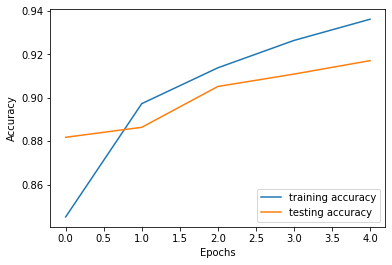

In [ ]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim=([0.5, 1])
plt.legend(loc='lower right')
plt.savefig("CNN 5 epochs", bbox_inches="tight", dpi=300)

**3.6 Test for the best lambda value and activation function to construct MLP**


In [ ]:
def create_LReLU_MLP(l2:float):
  mlp = MLP(
    LinearLayer(n_features, HIDDEN_SIZE, l2),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE, l2),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10, l2),
    SoftmaxOutputLayer())
  return mlp

100%|██████████| 10/10 [09:02<00:00, 54.21s/it]


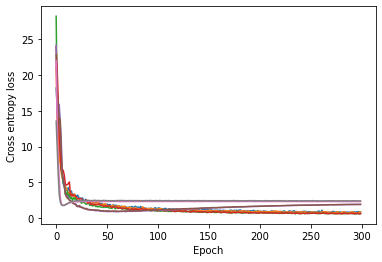

In [ ]:
import numpy as np
lambdas = np.logspace(-2,0,3)
accr = []
for la in lambdas:
  rmlp = create_ReLU_MLP(la)
  lrmlp = create_LReLU_MLP(la)
  rmlp.fit(1e-2, x_train, y_train, GRADIENT_STEPS,BATCH_SIZE)
  acc = accuracy_score(y_test, rmlp.predict(x_test))
  accr.append(acc)
  lrmlp.fit(1e-2, x_train, y_train, GRADIENT_STEPS,BATCH_SIZE)
  acc = accuracy_score(y_test, lrmlp.predict(x_test))
  accr.append(acc)



In [ ]:
best_ind = accr.index(max(accr))
best_lambda = lambdas[best_ind/2]
## best lambda: 0.1, best activation function: ReLU

**3.7 Different number of epochs**

100%|██████████| 30/30 [11:07<00:00, 22.25s/it]


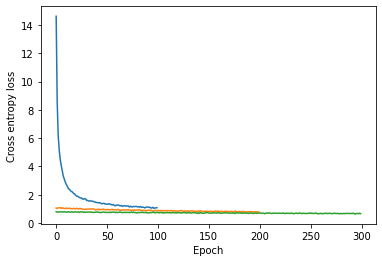

In [ ]:
num_epochs = [10,20,30]
acc_epochs = []
mlp = create_ReLU_MLP2(64, 0)
for k in range(3):
  mlp.fit(1e-2, x_train, y_train, num_epochs[k],6000)
  acc = accuracy_score(y_test, mlp.predict(x_test))
  acc_epochs.append(acc)

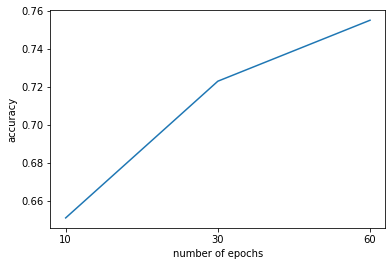

In [ ]:
xlabels = ['10', '30', '60']
x = np.arange(3)
plt.xticks(x, xlabels)
plt.ylabel("accuracy")
plt.xlabel("number of epochs")
plt.plot(x,acc_epochs)
plt.show()

**3.8 Creativity**

How different number of units affects the accuracy of MLP

In [ ]:
def create_ReLU_MLP2(unit:int, l2:float):
  mlp = MLP(
    LinearLayer(n_features, unit, l2),
    ReLULayer(),
    LinearLayer(unit, unit, l2),
    ReLULayer(),
    LinearLayer(unit, 10, l2),
    SoftmaxOutputLayer())
  return mlp

100%|██████████| 10/10 [04:14<00:00, 25.47s/it]


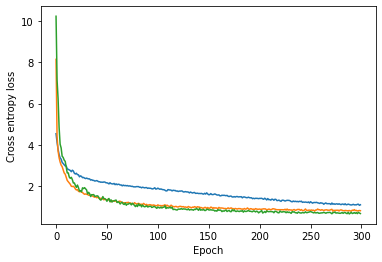

In [ ]:
diff_units = [16,32,64]
acc_unit = []
for k in range(3):
  mlp = create_ReLU_MLP2(diff_units[k], best_lambda)
  mlp.fit(1e-2, x_train, y_train, GRADIENT_STEPS,BATCH_SIZE)
  acc = accuracy_score(y_test, mlp.predict(x_test))
  acc_unit.append(acc)

In [ ]:
print(acc_unit)

[0.6339, 0.7057, 0.7494, 0.7661]


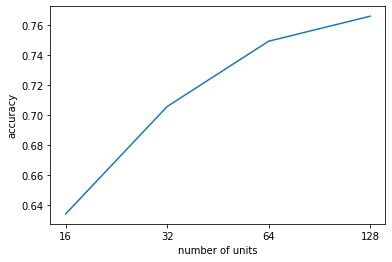

In [ ]:
xlabels = ['16', '32', '64', '128']
x = np.arange(4)
plt.xticks(x, xlabels)
plt.ylabel("accuracy")
plt.xlabel("number of units")
acc_unit.append(acc_l2)
plt.plot(x,acc_unit)
plt.show()

How different filter size affects the accuracy of CNN

In [ ]:
size = [2,3,4,5,6]
testing_acc = []
training_acc = []
for s in size:
  model = models.Sequential([
    layers.Conv2D(64, (s, s), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (s, s), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation ='relu'),
    layers.Dense(10, activation ='softmax')
  ])
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(training_images, training_labels, epochs=1, validation_data=(test_images, test_labels))
  training_acc.append(history.history['accuracy'])
  testing_acc.append(history.history['val_accuracy'])



1875/1875 [==============================] - 138s 73ms/step - loss: 0.4737 - accuracy: 0.8292 - val_loss: 0.4111 - val_accuracy: 0.8571


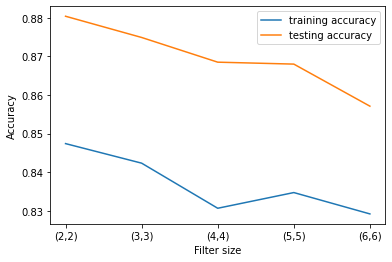

In [ ]:
loc = np.arange(5)
xlabels = ['(2,2)', '(3,3)', '(4,4)', '(5,5)', '(6,6)']
plt.plot(training_acc, label='training accuracy')
plt.plot(testing_acc, label='testing accuracy')
plt.xticks(loc, xlabels)
plt.xlabel('Filter size')
plt.ylabel('Accuracy')
plt.title('Accuracy w.r.t. different filter sizes')
plt.ylim=([0.5, 1])
plt.legend(loc='upper right')
plt.savefig("CNN filter size", bbox_inches="tight", dpi=300)